## Select Data

In [1]:
import pandas

class SelectData:

  def load_data(self, path):
    """
    Loads CSV data into a Pandas dataframe.
    """
    dataFrame = pandas.read_csv(path, sep=";")
    return dataFrame


  def save_data(self, SAVE_PATH, selectedData):
    """
    Saves selected data in dataframe to predefined CSV path.
    """
    selectedData.to_csv(SAVE_PATH, index=False, sep=";")


  def select_data(self, dataFrame):
    """
    Filters data from the loaded dataframe and returns the selection as a dataframe.
    """
    selectedData = dataFrame
    return selectedData


ACTORS_PATH = "dataset/actor_dataset.csv"
MOVIES_PATH = "dataset/movie_dataset.csv"
SAVE_PATH = "dataset/selected_data.csv"
sd = SelectData()

loadedData = sd.load_data(MOVIES_PATH)
selectedData = sd.select_data(loadedData).dropna()
sd.save_data(SAVE_PATH, selectedData)

## Create Database

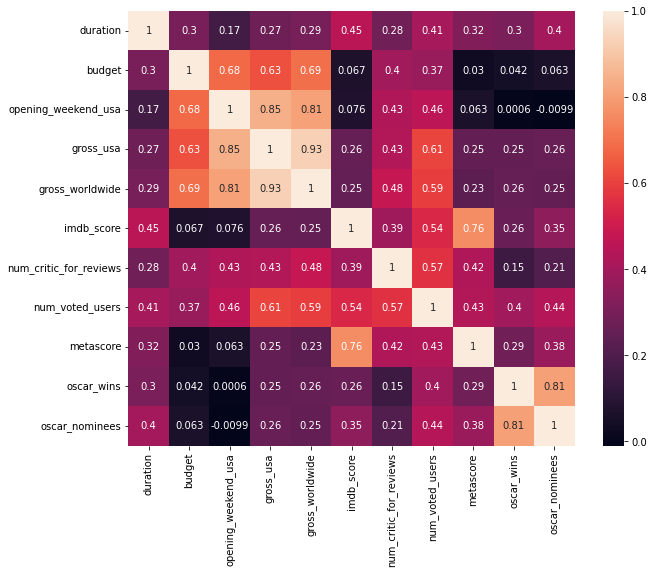

In [2]:
import csv
import sqlite3 
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

cor_heatmap_data = selectedData

class CreateDatabase:

  def create_database(self, cursor):
    """
    Creates a Sqlite database to store movie data.
    Fills in all data columns that I selected.
    """
    # Delete table if it exists.
    cursor.execute("""DROP TABLE IF EXISTS movies;""")

    # Creating a table with all the columns from the movies dataset
    sql_command = """
        CREATE TABLE movies (
        id INTEGER PRIMARY KEY,
        movie_title TEXT,
        director_name TEXT,
        summary TEXT,
        genres TEXT,
        release_date TEXT,
        duration INTEGER,
        budget REAL,
        opening_weekend_usa REAL,
        gross_usa REAL,
        gross_worldwide REAL,
        imdb_score REAL,
        num_critic_for_reviews REAL,
        num_voted_users REAL,
        metascore REAL,
        oscar_wins INTEGER,
        oscar_nominees INTEGER
        );"""

    cursor.execute(sql_command)
    
  def insert_into_database(self, cursor, data):
    """
    Loads all selected data from the CSV to the database.
    """
    column_names = "(movie_title, director_name, summary, genres, release_date, duration, budget, opening_weekend_usa, gross_usa, gross_worldwide, imdb_score, num_critic_for_reviews, num_voted_users, metascore, oscar_wins, oscar_nominees)"
    # Adding empty values as (?, ?, ..., ?) with the same amount of ? as column names
    values = "(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
    # Filling this list with tuples of values from the columns.
    # Each tuple represents one row.
    # Example: ("Avatar", "James Cameron", 2009-12-17, 162, 237000000, 760507625.0)
    insert_into_db = list(selectedData.itertuples(index=False, name=None))
    cursor.executemany(
        """INSERT INTO movies {} VALUES {};""".format(column_names, values), 
        insert_into_db
    )


data = None
DATA_PATH = "dataset/selected_data.csv"
DATABASE_PATH = "movies.db"
cb = CreateDatabase()

with open(DATA_PATH) as data_file:
  data = csv.reader(data_file, delimiter=";")

  connection = sqlite3.connect(DATABASE_PATH)
  cursor = connection.cursor()

  cb.create_database(cursor)
  cb.insert_into_database(cursor, data)

  connection.commit()
  connection.close()


# Here I create two functions similar to create_database and insert_into_database.
# This time, I create an actors table and fill it with actor data from actor_dataset.csv
# This will be added to the existing database movies.db

loadedActorData = sd.load_data(ACTORS_PATH)
selectedData = sd.select_data(loadedActorData)
sd.save_data(SAVE_PATH, selectedData)

class CreateActorsDatabase:
  def create_actor_database(self, cursor):
    """
    Creates a Sqlite database to store movie data.
    Fills in all data columns that I selected.
    """
    cursor.execute("""DROP TABLE IF EXISTS actors;""")
    sql_command_actors = """
        CREATE TABLE movies (
        id INTEGER PRIMARY KEY,
        movie_title TEXT,
        actor_1 TEXT,
        actor_2 TEXT,
        actor_3 TEXT,
        actor_4 TEXT,
        actor_5 TEXT,
        actor_6 TEXT,
        actor_7 TEXT,
        actor_8 TEXT,
        actor_9 TEXT,
        actor_10 TEXT;"""

    cursor.execute(sql_command_actors)

  def insert_actor_into_database(self, cursor, data):
    """
    Loads all selected data from the CSV to the database.
    """
    column_names = "(movie_title, actor_1, actor_2, actor_3, actor_4, actor_5, actor_6, actor_7, actor_8, actor_9, actor_10)"
    values = "(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"
    # Filling this list with tuples of values from the columns.
    # Each tuple represents one row.
    # Example: ("Avatar", "James Cameron", 2009-12-17, 162, 237000000, 760507625.0)
    insert_into_db = list(selectedData.itertuples(index=False, name=None))
    print(selectedData.columns)
    cursor.executemany(
        """INSERT INTO actirs {} VALUES {};""".format(column_names, values), 
        insert_into_db
    )

    data = None
    DATA_PATH = "dataset/selected_data.csv"
    DATABASE_PATH = "actors.db"
    cb = CreateActorsDatabase()

    with open(DATA_PATH) as data_file:
      data = csv.reader(data_file, delimiter=";")

      connection = sqlite3.connect(DATABASE_PATH)
      cursor = connection.cursor()

      cb.create_actor_database(cursor)
      cb.insert_actor_into_database(cursor, data)

    connection.commit()
    connection.close()

# Here I create a correlation heatmap in order to see which two features are correlated the most
data = cor_heatmap_data
df = pandas.DataFrame(data)
corrMatrix = df.corr()
plt.figure(figsize=(10,8))
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Query Database

In [3]:
class QueryDatabase:

  def get_data_x_from_database(self, connection):
    """
    Queries movies database for data to be used in model training.
    This function returns a list of tuples of parameters X.
    """
    # connection = sqlite3.connect(DATABASE_PATH)
    cursor = connection.cursor()

    # Here I replace the select statement with my own SQL query.
    # The query loads all necessary data for the next step of training a model.
    # I return the data as a list of tuples of parameters X.
    # e.g. [("Avatar", "James Cameron", 2009-12-17, 162, 760507625.0), ("Spider-Man 3", "Sam Raimi", 2007-05-01, 139, 151116516.0)]
    # select_statement = "SELECT budget, opening_weekend_usa, gross_usa FROM movies"
    select_statement = "SELECT gross_usa FROM movies"

    cursor.execute(select_statement)

    data = cursor.fetchall()
    return data

  def get_data_y_from_database(self, connection):
    """
    Queries movies database for data to be used in model training.
    This function returns a list of the predicted value Y.
    """
    cursor = connection.cursor()

    # Here I replace the select statement with my own SQL query.
    # The query loads all necessary data for the next step of training a model.
    # I return the data as a list of predicted box office values Y.
    # e.g. [237000000, 258000000]
    select_statement = "SELECT gross_worldwide FROM movies"

    cursor.execute(select_statement)

    data = cursor.fetchall()
    return data


DATABASE_PATH = "movies.db"
qd = QueryDatabase()

connection = sqlite3.connect(DATABASE_PATH)
data = qd.get_data_x_from_database(connection)

# These print statements are here just to test if the code works.
# The function get_data_from_database will be used to retrieve data in trainModel.py
if data:
  print("Selecting data from database succeeded.")
  print("First 10 rows of data")
  for row in data[:10]:
      print(row)
else:
  print("Selecting data failed.")

connection.commit()
connection.close()

Selecting data from database succeeded.
First 10 rows of data
(760507625.0,)
(309420425.0,)
(200074175.0,)
(448139099.0,)
(73078100.0,)
(336530303.0,)
(200821936.0,)
(459005868.0,)
(301959197.0,)
(330360194.0,)


## Train Model

Coefficients: 
 [[2.53079778]]
Mean squared error: 4891107526899411.00
Variance score: 0.82


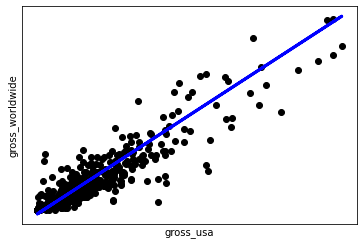

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

class TrainModel:

  def create_model(self):
    """
    Creates the model.
    """
    # Here I select a sklearn model: linear regression.
    # The goal is to predict the box office value from a set of movie parameters: gross_usa and gross_worldwide.
    model = LinearRegression()
    return model


  def train_model(self, model, data_x, data_y):
    """
    Trains the model.
    """
    # Here I train/fit the model using the movie parameters X and the box office value Y.
    model.fit(data_x, data_y)


  def test_model(self, model, data_x, data_y):
    """
    Tests the model by printing error measurements and plotting the real data and predictions.
    """
    # Here I make the predictions using the test set.
    predictions_y = model.predict(data_x)

    # Print the parameter coefficients.
    print('Coefficients: \n', model.coef_)
    # Print the mean squared error.
    print("Mean squared error: %.2f"
          % mean_squared_error(data_y, predictions_y))
    # Explained variance score: 1 is perfect prediction.
    print('Variance score: %.2f' % r2_score(data_y, predictions_y))

    # Plotting results
    plt.scatter(data_x, data_y, color='black')
    plt.plot(data_x, predictions_y, color='blue', linewidth=3)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("gross_usa")
    plt.ylabel("gross_worldwide")
    plt.show()


DATABASE_PATH = "movies.db"
tm = TrainModel()
qd = QueryDatabase()

connection = sqlite3.connect(DATABASE_PATH)

data_x = qd.get_data_x_from_database(connection)
data_y = qd.get_data_y_from_database(connection)

connection.commit()
connection.close()

train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(data_x, data_y)

model = tm.create_model()
tm.train_model(model, train_data_x, train_data_y)
tm.test_model(model, test_data_x, test_data_y)
